### Import Modules

In [1]:
from config_VVV_IRAC import *
import matplotlib.pyplot as plt

import os, glob
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.colors import LogNorm

import os, sys, time, glob, copy
# import warnings
# import itertools

# from astropy.io import fits

# import cv2
# import argparse
# from PIL import Image

# import torch
# import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.model_selection import train_test_split

# import torchvision
# from torchvision import transforms
# from torchvision.utils import save_image

import pickle
# import json
from tqdm import tqdm

In [3]:
# from config import *
# from utils import GridVisualizer
from utils import weights_init_normal, LambdaLR
from utils import save_checkpoint, load_checkpoint, load_checkpoint_for_test
from utils import save_checkpoint_Sep_Gen, load_checkpoint_Sep_Gen
from utils import update_buffer, sample_buffer
from utils import allocate_memory
from utils import extract_first_batch
from utils import LossManager
from utils import GenSepLossManager
# from dataset import ImageStacker, ImageAugmentation
# from config import transform
from dataset import CustomDataset, data_split
from model import Discriminator # Generator
from utils import ResultVisualizer
# from utils import ProjectionVisualizer

In [4]:
# from config import *
# from config_VVV_IRAC import *
# from utils import GridVisualizer
# from dataset import FitsArrayConverter
from dataset import ImageStacker, ImageAugmentation

### Configuration
#### Basic Settings

In [6]:
if torch.cuda.is_available():
    torch.cuda.set_device(1)
    device = "cuda:1"

In [5]:
# Editable Options
channels_order = ['H', 'K', 'ch2']
match_output_channel_num = True   ###
lambda_identity = 5.0   ###

stacking_size = 174
dirname = f'registrated_gc_180x180_extraction'
save_dir = root_dir+'/data_added/registrated_sparse_cropped_gc_180x180_extraction/merged_3ch'
add_suffix='_to_3_channels_registration_sparse_cropped_VVV'   # for saving files

# Channel Number (Derived)
input_nc = len(channels_order)  # 6
if match_output_channel_num:
    output_nc = input_nc
else:
    output_nc = 1

In [6]:
print(f'Base Directory: {root_dir}')
print('Device:', device)
print(f"Number of CPU Cores: {num_cores}")

Base Directory: /home/jiwon/UKIDSSxIRAC
Device: cuda:1
Number of CPU Cores: 32


### Data Preparation

#### Image Stacking & Augmentation

##### Stacking 6-channel Image

**Options & Filename**

- `000000_X.npy`
<br/>
    ```python3
    ImageStacker(save_dir, normalization=False, logarithm=False, standardization=False,
                 channel_matching=match_output_channel_num, marking=False)    
    ```

- `000000_norm_X.npy`
<br/>
    ```python3
    ImageStacker(save_dir, normalization=True, logarithm=False, standardization=False,
                 channel_matching=match_output_channel_num, marking=True)   

- `000000_log_X.npy`
<br/>
    ```python3
    ImageStacker(save_dir, normalization=False, logarithm=True, standardization=False,
                 channel_matching=match_output_channel_num, marking=True)   
    ```

- `000000_std_X.npy`
<br/>
    ```python3
    ImageStacker(save_dir, normalization=False, logarithm=False, standardization=True,
                 channel_matching=match_output_channel_num, marking=True)   
    ```


In [7]:
img_stacker = ImageStacker(save_dir, normalization=True, logarithm=False, standardization=False,
                           channel_matching=match_output_channel_num, marking=True, pre_processed=False,
                           channels_order=channels_order, pop_channel='ch1')

#### Load Source Information

In [9]:
# import pandas as pd
# from astropy.coordinates import SkyCoord
# import astropy.units as u

# class ConvertCoord():
#     def __init__(self):
#         pass
    
#     def load_dataframe(self, filename=None, sep='\t', header=None, names=None, rename=False,
#                        dataframe=None, verbose=False):
#         if (filename is None) and (dataframe is None):
#             raise ValueError("Either a filename or a DataFrame must be provided.")
#         if (filename is not None) and (dataframe is not None):
#             raise ValueError("Both filename and DataFrame cannot be provided simultaneously.")

#         if dataframe is not None:
#             df = dataframe
#         if filename is not None:
#             if header is None:
#                 names = ['RA', 'Dec', 'ID']
#             df = pd.read_csv(filename, sep=sep, header=header, names=names, dtype={'ID': str})
#             if header is not None and rename:
#                 df = self.rename_columns(df, rename_values=None)
#         if verbose:
#             print(df.head())
#         return df

#     def rename_columns(self, df, rename_values=None):
#         if rename_values is None:
#             rename_values = ['RA', 'Dec', 'ID']
#         input_keys = df.columns.tolist()
#         if len(input_keys) != len(rename_values):
#             raise ValueError(f"Expected {len(rename_values)} columns, but got {len(input_keys)}.")
#         rename_map = dict(zip(input_keys, rename_values))
#         print("Before renaming:", df.columns.tolist())
#         df = df.rename(columns=rename_map)
#         print("After renaming:", df.columns.tolist())
#         return df

#     def convert_row(self, row):
#         coord = SkyCoord(ra=row["RA"], dec=row["Dec"], unit=(u.hourangle, u.deg), frame='icrs')
#         return pd.Series({'RA': coord.ra.deg, 'Dec': coord.dec.deg})
    
#     def convert_to_deg(self, df, verbose=False):
#         df[["RA", "Dec"]] = df.apply(lambda row: self.convert_row(row), axis=1)
#         if verbose:
#             print('\n', df.head(),'\n')
#             print(f"Confirm Data Type - RA: {type(df['RA'][0])}, Dec: {type(df['Dec'][0])}")
#         return df

#     def add_galactic_coord(self, df, verbose=False):
#         coords = SkyCoord(ra=df['RA'].values * u.deg, dec=df['Dec'].values * u.deg, frame='icrs')
#         df['GLON'] = coords.galactic.l.deg
#         df['GLAT'] = coords.galactic.b.deg
#         df['Adjusted_GLON'] = df['GLON'].apply(lambda x: x - 360 if x > 180 else x)

#         if verbose:
#             print('\n', df.head(),'\n')
#         return df

In [10]:
# convert_coord = ConvertCoord()

# df_filename = 'targetlist_filtered_sources_with_source_name.txt'
# df = convert_coord.load_dataframe(df_filename, sep=',', header=0, names=['RA', 'Dec', 'ID'])
# # df = convert_coord.add_galactic_coord(df)

# coords_center = SkyCoord(ra=df['RA'].values * u.deg, dec=df['Dec'].values * u.deg, frame='icrs')
# df['RA_Dec_String'] = [
#     f"{ra_hms}{dec_dms}" for ra_hms, dec_dms in zip(
#         coords_center.ra.to_string(unit=u.hour, sep='', precision=1),
#         coords_center.dec.to_string(unit=u.deg, sep='', precision=0))]
# df['Converted_FileName'] = [
#     f"{i+1:04}_{ra_dec}_" for i, ra_dec in enumerate(df['RA_Dec_String'])]

# print(f'Shape of the Data Frame: {df.shape}')
# df.head()

### Data Loader

In [8]:
sourcelist = np.loadtxt(os.path.join(root_dir, "source_list_VVV_IRAC_sparse_cropped_3ch.txt"), dtype='str')

In [9]:
image_dir = []  # Augmentation 데이터 포함 시 탐색 방안 바꿔야

for i, source in enumerate(sourcelist):
    image_pathlist = {}
    filenames = img_stacker.save_name(save_dir,source,'npy')
    image_pathlist['X'], image_pathlist['y'] = filenames
    image_dir.append(image_pathlist)

print(image_pathlist)

{'X': '/home/jiwon/UKIDSSxIRAC/data_added/registrated_sparse_cropped_gc_180x180_extraction/merged_3ch/0684_174512.4-284044_X_norm.npy', 'y': '/home/jiwon/UKIDSSxIRAC/data_added/registrated_sparse_cropped_gc_180x180_extraction/merged_3ch/0684_174512.4-284044_y_norm.npy'}


In [10]:
dataset_dir = root_dir+'/dataset'

In [11]:
# Split Data into Train/Val/Test 
suffix = f'_vvv_irac_sparse_cropped_{stacking_size}x{stacking_size}_{input_nc}_channels_to_{output_nc}_channels{img_stacker.mark_on_name()}_registration'
data_split(image_dir, save_dir=dataset_dir, savename_suffix=suffix)

# Load Train & Val Data
with open(f'{dataset_dir}/train_data{suffix}.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open(f'{dataset_dir}/val_data{suffix}.pkl', 'rb') as f:
    val_data = pickle.load(f)

# Define Dataset & Data Loader
train_dataset = CustomDataset(train_data, transform=transform)
val_dataset = CustomDataset(val_data, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Train set: 90 samples
Validation set: 31 samples
Test set: 31 samples


### Model

In [12]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(input_nc, 64, kernel_size=7, padding=3),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )
        
        # Residual Blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(nn.Sequential(
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.InstanceNorm2d(256),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.InstanceNorm2d(256)
            ))
        self.residual_blocks = nn.Sequential(*res_blocks)

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=0),  # output_padding=1로 수정
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # output_padding=1로 수정
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, output_nc, kernel_size=7, padding=3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)        
        x = self.residual_blocks(x) + x  # 잔차 연결        
        x = self.decoder(x)
        return x

In [13]:
max_epochs=150

In [14]:
# Networks
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)
netD_A = Discriminator(input_nc).to(device)
netD_B = Discriminator(output_nc).to(device)

# Apply Weight Initialize
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Losses
criterion_GAN = torch.nn.MSELoss()  ### Check
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

# Optimizers
optimizer_G_A2B = optim.Adam(netG_A2B.parameters(), lr=learning_rate, betas=betas)#, weight_decay=weight_decay)
optimizer_G_B2A = optim.Adam(netG_B2A.parameters(), lr=learning_rate, betas=betas)#, weight_decay=weight_decay)
optimizer_D_A = optim.Adam(netD_A.parameters(), lr=learning_rate, betas=betas) #, weight_decay=weight_decay)
optimizer_D_B = optim.Adam(netD_B.parameters(), lr=learning_rate, betas=betas) #, weight_decay=weight_decay)

# Scheduler
lr_scheduler_G_A2B = lr_scheduler.LambdaLR(optimizer_G_A2B, lr_lambda=LambdaLR(max_epochs, start_epoch, decay_epoch).step)
lr_scheduler_G_B2A = lr_scheduler.LambdaLR(optimizer_G_B2A, lr_lambda=LambdaLR(max_epochs, start_epoch, decay_epoch).step)
lr_scheduler_D_A = lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(max_epochs, start_epoch, decay_epoch).step)
lr_scheduler_D_B = lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(max_epochs, start_epoch, decay_epoch).step)

### Train

In [15]:
stacking_size

174

In [25]:
# Memory Allocation
input_A, input_B, target_real, target_fake = allocate_memory(input_nc=input_nc, output_nc=output_nc, netD_A=netD_A, stacking_size=stacking_size)
print(input_A.shape)
print(input_B.shape)
print(target_real.shape)
print(target_fake.shape)

torch.Size([1, 3, 174, 174])
torch.Size([1, 3, 174, 174])
torch.Size([1, 1, 19, 19])
torch.Size([1, 1, 19, 19])


In [26]:
# Buffers for generated images
fake_A_buffer = []
fake_B_buffer = []

# Best Model Score
best_val_loss = float('inf')

# Loss Save List
G_A2B_losses = []
G_B2A_losses = []
D_A_losses = []
D_B_losses = []
val_G_A2B_losses = []
val_G_B2A_losses = []
val_D_A_losses = []
val_D_B_losses = []

In [27]:
if not os.path.exists(root_dir+'/result/model_params'):
    print(f'\n=== Making "result/model_params" Directory ===\n')
    os.makedirs(root_dir+'/result/model_params')

In [28]:
max_epochs = 3

In [ ]:
for epoch in range(max_epochs):
    start_time = time.time()

    ##--- [[ Training ]] ---##

    netG_A2B.train()
    netG_B2A.train()
    netD_A.train()
    netD_B.train()

    # Initialize epoch loss
    epoch_loss_G_A2B = 0.0
    epoch_loss_G_B2A = 0.0    
    epoch_loss_D_A = 0.0
    epoch_loss_D_B = 0.0

    for i, (real_A, real_B) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epochs}', leave=True)):
        real_A = real_A.to(device)
        real_B = real_B.to(device)
        
        #--- [ Generator A2B ] ---#
        optimizer_G_A2B.zero_grad()

        # Identity Loss
        if lambda_identity > 0.0:
            same_B = netG_A2B(real_B)
            loss_identity_B = criterion_identity(same_B, real_B)*lambda_identity
        else:
            loss_identity_B = 0.0

        # GAN Loss
        fake_B = netG_A2B(real_A)
        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        # Cycle Loss (A -> B -> A)
        recovered_A = netG_B2A(fake_B)
        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*lambda_cycle

        # Total Loss for Generator A2B
        loss_G_A2B = loss_identity_B + loss_GAN_A2B + loss_cycle_ABA
        epoch_loss_G_A2B += loss_G_A2B.item()
        loss_G_A2B.backward()

        optimizer_G_A2B.step()  # Gradient Update for Generator A2B
        

         #--- [ Generator B2A ] ---#
        optimizer_G_B2A.zero_grad()

        # Identity Loss
        if lambda_identity > 0.0:
            same_A = netG_B2A(real_A)
            loss_identity_A = criterion_identity(same_A, real_A)*lambda_identity
        else:
            loss_identity_A = 0.0

        # GAN Loss
        fake_A = netG_B2A(real_B)
        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        # Cycle Loss (B -> A -> B)
        recovered_B = netG_A2B(fake_A)
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*lambda_cycle

        # Total Loss for Generator B2A
        loss_G_B2A = loss_identity_A + loss_GAN_B2A + loss_cycle_BAB
        epoch_loss_G_B2A += loss_G_B2A.item()
        loss_G_B2A.backward()

        optimizer_G_B2A.step()  # Gradient Update for Generator B2A


        #--- [ Discriminator A ] ---#
        optimizer_D_A.zero_grad()
        
        # Real Loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake Loss
        fake_A = sample_buffer(fake_A_buffer, fake_A) ### Check
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total Loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        epoch_loss_D_A += loss_D_A.item()
        loss_D_A.backward()

        optimizer_D_A.step() # Gradient Update


        #--- [ Discriminator B ] ---#
        optimizer_D_B.zero_grad()

        # Real Loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)
        
        # Fake Loss
        fake_B = sample_buffer(fake_B_buffer, fake_B) ### Check
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total Loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        epoch_loss_D_B += loss_D_B.item()
        loss_D_B.backward()

        optimizer_D_B.step() # Gradient Update

    # Save Loss Value
    G_A2B_losses.append(epoch_loss_G_A2B / len(train_loader))
    G_B2A_losses.append(epoch_loss_G_B2A / len(train_loader))
    D_A_losses.append(epoch_loss_D_A / len(train_loader))
    D_B_losses.append(epoch_loss_D_B / len(train_loader))

    end_time = time.time()
    epoch_duration = end_time - start_time
    # tqdm.write(f'Epoch [{epoch+1}/{max_epochs}] completed in {epoch_duration:.2f} seconds.')

    # Update Learning Rates
    lr_scheduler_G_A2B.step()
    lr_scheduler_G_B2A.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    ##--- [[ Validation ]] ---##

    netG_A2B.eval()
    netG_B2A.eval()
    netD_A.eval()
    netD_B.eval()

    val_loss_G_A2B = 0.0
    val_loss_G_B2A = 0.0
    val_loss_D_A = 0.0
    val_loss_D_B = 0.0

    with torch.no_grad():
        for val_real_A, val_real_B in val_loader:
            val_real_A = val_real_A.to(device)
            val_real_B = val_real_B.to(device)
        
            #--- [ Generator A2B (Val) ] ---#
            
            # Identity Loss
            if lambda_identity > 0.0:
                val_same_B = netG_A2B(val_real_B).detach()
                val_loss_identity_B = criterion_identity(val_same_B, val_real_B)*lambda_identity
            else:
                val_loss_identity_B = 0.0

            # GAN Loss
            val_fake_B = netG_A2B(val_real_A).detach()
            val_pred_fake = netD_B(val_fake_B)
            val_loss_GAN_A2B = criterion_GAN(val_pred_fake, target_real)

            # Cycle Loss
            val_recovered_A = netG_B2A(val_fake_B).detach()
            val_loss_cycle_ABA = criterion_cycle(val_recovered_A, val_real_A)*lambda_cycle

            # Total Generator A2B Loss
            val_loss_G_A2B += (val_loss_identity_B + val_loss_GAN_A2B + val_loss_cycle_ABA).item()


            #--- [ Generator B2A (Val) ] ---#
            
            # Identity Loss
            if lambda_identity > 0.0:
                val_same_A = netG_B2A(val_real_A).detach()
                val_loss_identity_A = criterion_identity(val_same_A, val_real_A)*lambda_identity
            else:
                val_loss_identity_A = 0.0

            # GAN Loss
            val_fake_A = netG_B2A(val_real_B).detach()
            val_pred_fake = netD_A(val_fake_A)
            val_loss_GAN_B2A = criterion_GAN(val_pred_fake, target_real)

            # Cycle Loss
            val_recovered_B = netG_A2B(val_fake_A).detach()
            val_loss_cycle_BAB = criterion_cycle(val_recovered_B, val_real_B)*lambda_cycle

            # Total Generator B2A Loss
            val_loss_G_B2A += (val_loss_identity_A + val_loss_GAN_B2A + val_loss_cycle_BAB).item()

            
            # --- [ Discriminator A (Val) ] --- #

            # Real Loss
            val_pred_real = netD_A(val_real_A)
            val_loss_D_real = criterion_GAN(val_pred_real, target_real)
            
            # Fake Loss
            val_pred_fake = netD_A(val_fake_A.detach())
            val_loss_D_fake = criterion_GAN(val_pred_fake, target_fake)

            # Total Loss
            val_loss_D_A += (val_loss_D_real + val_loss_D_fake).item() * 0.5


            # --- [ Discriminator B (Val) ] --- #

            # Real Loss
            val_pred_real = netD_B(val_real_B)
            val_loss_D_real = criterion_GAN(val_pred_real, target_real)

            # Fake Loss
            val_pred_fake = netD_B(val_fake_B.detach())
            val_loss_D_fake = criterion_GAN(val_pred_fake, target_fake)

            # Total Loss
            val_loss_D_B += (val_loss_D_real + val_loss_D_fake).item() * 0.5

    # Save Validation Loss Value
    val_G_A2B_losses.append(val_loss_G_A2B / len(val_loader))
    val_G_B2A_losses.append(val_loss_G_B2A / len(val_loader))
    val_D_A_losses.append(val_loss_D_A / len(val_loader))
    val_D_B_losses.append(val_loss_D_B / len(val_loader))

    tqdm.write(f'Validation - G_A2B Loss: {val_G_A2B_losses[-1]:.4f}, G_B2A Loss: {val_G_B2A_losses[-1]:.4f}, D_A Loss: {val_D_A_losses[-1]:.4f}, D_B Loss: {val_D_B_losses[-1]:.4f}')

    # Save Models
    if val_loss_G_B2A < best_val_loss:
        best_val_loss = val_loss_G_B2A
        best_epoch = epoch + 1
        save_checkpoint_Sep_Gen(epoch+1, netG_A2B, netG_B2A, netD_A, netD_B, 
                                optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B, 
                                lr_scheduler_G_A2B, lr_scheduler_G_B2A, lr_scheduler_D_A, lr_scheduler_D_B, 
                                best_val_loss, best_epoch, stacking_size=stacking_size, input_nc=input_nc,
                                status='best', pre_processed=img_stacker.mark_on_name(), add_suffix=add_suffix)

    if (epoch + 1) % 20 == 0: 
        save_checkpoint_Sep_Gen(epoch+1, netG_A2B, netG_B2A, netD_A, netD_B, 
                                optimizer_G_A2B, optimizer_G_B2A, optimizer_D_A, optimizer_D_B, 
                                lr_scheduler_G_A2B, lr_scheduler_G_B2A, lr_scheduler_D_A, lr_scheduler_D_B, 
                                best_val_loss, best_epoch, stacking_size=stacking_size, input_nc=input_nc,
                                status=f'epoch_{epoch+1}', pre_processed=img_stacker.mark_on_name(), add_suffix=add_suffix)


Epoch 1/150:   0%|          | 0/90 [00:00<?, ?it/s]

Epoch 1/150: 100%|██████████| 90/90 [00:37<00:00,  2.39it/s]


Validation - G_A2B Loss: 1.3621, G_B2A Loss: 1.0450, D_A Loss: 0.1893, D_B Loss: 0.1740


/compuworks/anaconda3/envs/python3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 2/150: 100%|██████████| 90/90 [00:35<00:00,  2.55it/s]


Validation - G_A2B Loss: 0.9357, G_B2A Loss: 0.9112, D_A Loss: 0.1510, D_B Loss: 0.2401
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 3/150: 100%|██████████| 90/90 [00:35<00:00,  2.50it/s]


Validation - G_A2B Loss: 0.9666, G_B2A Loss: 0.7279, D_A Loss: 0.1567, D_B Loss: 0.1135
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 4/150: 100%|██████████| 90/90 [00:37<00:00,  2.43it/s]


Validation - G_A2B Loss: 0.8539, G_B2A Loss: 0.8679, D_A Loss: 0.1033, D_B Loss: 0.1285


Epoch 5/150: 100%|██████████| 90/90 [00:37<00:00,  2.37it/s]


Validation - G_A2B Loss: 0.9527, G_B2A Loss: 0.5539, D_A Loss: 0.2664, D_B Loss: 0.1631
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 6/150: 100%|██████████| 90/90 [00:36<00:00,  2.46it/s]


Validation - G_A2B Loss: 1.4525, G_B2A Loss: 0.7762, D_A Loss: 0.2261, D_B Loss: 0.0391


Epoch 7/150: 100%|██████████| 90/90 [00:37<00:00,  2.38it/s]


Validation - G_A2B Loss: 0.9700, G_B2A Loss: 0.7412, D_A Loss: 0.1305, D_B Loss: 0.1822


Epoch 8/150: 100%|██████████| 90/90 [00:35<00:00,  2.55it/s]


Validation - G_A2B Loss: 0.6005, G_B2A Loss: 0.7718, D_A Loss: 0.1444, D_B Loss: 0.6340


Epoch 9/150: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Validation - G_A2B Loss: 0.6106, G_B2A Loss: 0.5616, D_A Loss: 0.2455, D_B Loss: 0.2625


Epoch 10/150: 100%|██████████| 90/90 [00:35<00:00,  2.56it/s]


Validation - G_A2B Loss: 1.0098, G_B2A Loss: 0.4483, D_A Loss: 0.3652, D_B Loss: 0.0684
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 11/150: 100%|██████████| 90/90 [00:35<00:00,  2.52it/s]


Validation - G_A2B Loss: 1.3808, G_B2A Loss: 1.0677, D_A Loss: 0.1315, D_B Loss: 0.0870


Epoch 12/150: 100%|██████████| 90/90 [00:34<00:00,  2.65it/s]


Validation - G_A2B Loss: 0.8726, G_B2A Loss: 0.5203, D_A Loss: 0.2286, D_B Loss: 0.1883


Epoch 13/150: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Validation - G_A2B Loss: 0.9490, G_B2A Loss: 0.6848, D_A Loss: 0.1628, D_B Loss: 0.3237


Epoch 14/150: 100%|██████████| 90/90 [00:35<00:00,  2.55it/s]


Validation - G_A2B Loss: 1.3656, G_B2A Loss: 0.8129, D_A Loss: 0.1297, D_B Loss: 0.2080


Epoch 15/150: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


Validation - G_A2B Loss: 0.6282, G_B2A Loss: 0.5255, D_A Loss: 0.2221, D_B Loss: 0.4872


Epoch 16/150: 100%|██████████| 90/90 [00:34<00:00,  2.65it/s]


Validation - G_A2B Loss: 0.7736, G_B2A Loss: 0.5776, D_A Loss: 0.1683, D_B Loss: 0.1614


Epoch 17/150: 100%|██████████| 90/90 [00:34<00:00,  2.58it/s]


Validation - G_A2B Loss: 0.7526, G_B2A Loss: 0.6087, D_A Loss: 0.1696, D_B Loss: 0.1745


Epoch 18/150: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Validation - G_A2B Loss: 1.8662, G_B2A Loss: 0.7117, D_A Loss: 0.1833, D_B Loss: 0.0564


Epoch 19/150: 100%|██████████| 90/90 [00:34<00:00,  2.61it/s]


Validation - G_A2B Loss: 1.1590, G_B2A Loss: 0.6573, D_A Loss: 0.1771, D_B Loss: 0.0324


Epoch 20/150: 100%|██████████| 90/90 [00:35<00:00,  2.57it/s]


Validation - G_A2B Loss: 1.4575, G_B2A Loss: 0.9969, D_A Loss: 0.2190, D_B Loss: 0.0226
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_epoch_20_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 21/150: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Validation - G_A2B Loss: 1.4633, G_B2A Loss: 0.6360, D_A Loss: 0.2078, D_B Loss: 0.0063


Epoch 22/150: 100%|██████████| 90/90 [00:34<00:00,  2.62it/s]


Validation - G_A2B Loss: 1.4081, G_B2A Loss: 0.7101, D_A Loss: 0.1685, D_B Loss: 0.0207


Epoch 23/150: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Validation - G_A2B Loss: 1.7033, G_B2A Loss: 0.5469, D_A Loss: 0.3997, D_B Loss: 0.0095


Epoch 24/150: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Validation - G_A2B Loss: 1.3940, G_B2A Loss: 0.3943, D_A Loss: 0.3249, D_B Loss: 0.0035
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 25/150: 100%|██████████| 90/90 [00:34<00:00,  2.59it/s]


Validation - G_A2B Loss: 1.7585, G_B2A Loss: 1.0702, D_A Loss: 0.1314, D_B Loss: 0.0211


Epoch 26/150: 100%|██████████| 90/90 [00:32<00:00,  2.80it/s]


Validation - G_A2B Loss: 1.5784, G_B2A Loss: 0.8297, D_A Loss: 0.1621, D_B Loss: 0.0108


Epoch 27/150: 100%|██████████| 90/90 [00:34<00:00,  2.59it/s]


Validation - G_A2B Loss: 1.5285, G_B2A Loss: 0.5387, D_A Loss: 0.2153, D_B Loss: 0.0021


Epoch 28/150: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Validation - G_A2B Loss: 1.3131, G_B2A Loss: 0.4941, D_A Loss: 0.2138, D_B Loss: 0.0293


Epoch 29/150: 100%|██████████| 90/90 [00:36<00:00,  2.50it/s]


Validation - G_A2B Loss: 1.4829, G_B2A Loss: 0.4853, D_A Loss: 0.2181, D_B Loss: 0.0025


Epoch 30/150: 100%|██████████| 90/90 [00:35<00:00,  2.54it/s]


Validation - G_A2B Loss: 1.2781, G_B2A Loss: 0.6045, D_A Loss: 0.1420, D_B Loss: 0.0111


Epoch 31/150: 100%|██████████| 90/90 [00:36<00:00,  2.50it/s]


Validation - G_A2B Loss: 1.3463, G_B2A Loss: 0.8239, D_A Loss: 0.1049, D_B Loss: 0.0119


Epoch 32/150: 100%|██████████| 90/90 [00:35<00:00,  2.57it/s]


Validation - G_A2B Loss: 1.5439, G_B2A Loss: 0.7947, D_A Loss: 0.1345, D_B Loss: 0.0017


Epoch 33/150: 100%|██████████| 90/90 [00:32<00:00,  2.74it/s]


Validation - G_A2B Loss: 1.4812, G_B2A Loss: 0.5718, D_A Loss: 0.2688, D_B Loss: 0.0028


Epoch 34/150: 100%|██████████| 90/90 [00:33<00:00,  2.67it/s]


Validation - G_A2B Loss: 1.4508, G_B2A Loss: 0.8320, D_A Loss: 0.1777, D_B Loss: 0.0040


Epoch 35/150: 100%|██████████| 90/90 [00:33<00:00,  2.66it/s]


Validation - G_A2B Loss: 1.5527, G_B2A Loss: 0.5927, D_A Loss: 0.2495, D_B Loss: 0.0014


Epoch 36/150: 100%|██████████| 90/90 [00:35<00:00,  2.53it/s]


Validation - G_A2B Loss: 1.4807, G_B2A Loss: 0.6168, D_A Loss: 0.2474, D_B Loss: 0.0010


Epoch 37/150: 100%|██████████| 90/90 [00:33<00:00,  2.68it/s]


Validation - G_A2B Loss: 2.0163, G_B2A Loss: 1.2063, D_A Loss: 0.1129, D_B Loss: 0.0409


Epoch 38/150: 100%|██████████| 90/90 [00:32<00:00,  2.79it/s]


Validation - G_A2B Loss: 1.5253, G_B2A Loss: 0.7944, D_A Loss: 0.2246, D_B Loss: 0.0039


Epoch 39/150: 100%|██████████| 90/90 [00:34<00:00,  2.60it/s]


Validation - G_A2B Loss: 1.4463, G_B2A Loss: 1.2057, D_A Loss: 0.2880, D_B Loss: 0.0214


Epoch 40/150: 100%|██████████| 90/90 [00:35<00:00,  2.57it/s]


Validation - G_A2B Loss: 1.3531, G_B2A Loss: 0.4853, D_A Loss: 0.2377, D_B Loss: 0.0074
Saved as /home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_epoch_40_174x174_3_channels_to_3_channels_registration_sparse_cropped_VVV_norm.pth


Epoch 41/150:  28%|██▊       | 25/90 [00:11<00:22,  2.83it/s]

In [22]:
# -- [ When Error ]
fake_B = netG_A2B(real_A)
pred_fake = netD_B(fake_B)

# 차원 확인
print(f"real_A shape: {real_A.shape}")  # real_A의 차원 확인
print(f"fake_B shape: {fake_B.shape}")  # 생성된 fake_B의 차원 확인

print(f"pred_fake shape: {pred_fake.shape}")  # 판별기 출력 pred_fake의 차원 확인
print(f"target_real shape: {target_real.shape}")  # target_real의 차원 확인

real_A shape: torch.Size([1, 6, 174, 174])
fake_B shape: torch.Size([1, 6, 174, 174])
pred_fake shape: torch.Size([1, 1, 19, 19])
target_real shape: torch.Size([1, 1, 19, 19])


In [23]:
loss_logger = GenSepLossManager(input_nc=input_nc, pre_processed=img_stacker.mark_on_name(), stacking_size=stacking_size, add_suffix=add_suffix)
loss_logger.save_loss(
    G_A2B_losses=G_A2B_losses, 
    G_B2A_losses=G_B2A_losses, 
    D_A_losses=D_A_losses, 
    D_B_losses=D_B_losses, 
    val_G_A2B_losses=val_G_A2B_losses, 
    val_G_B2A_losses=val_G_B2A_losses, 
    val_D_A_losses=val_D_A_losses, 
    val_D_B_losses=val_D_B_losses
)

Loss Saved: /home/jiwon/UKIDSSxIRAC/result/losses_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm.json


Loss Loaded: /home/jiwon/UKIDSSxIRAC/result/losses_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm.json


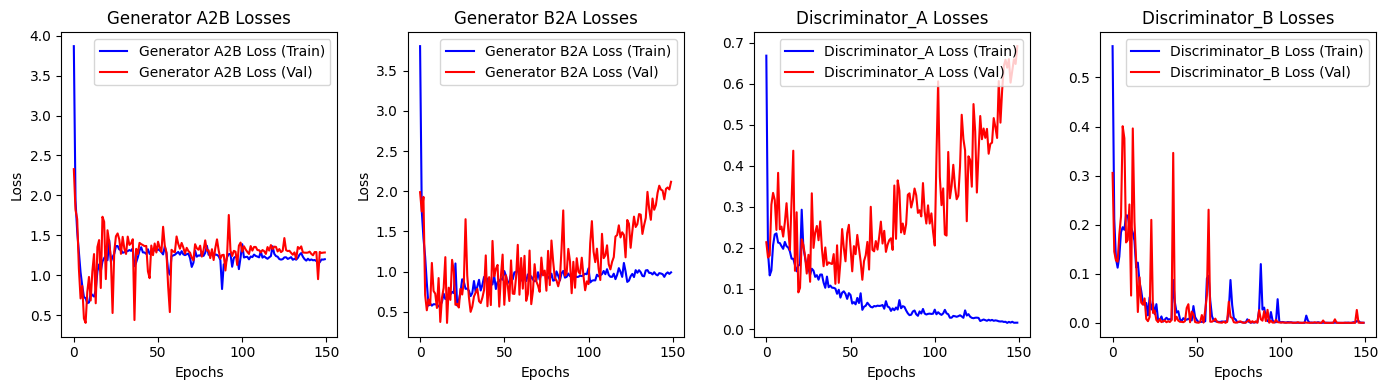

In [24]:
loss_logger = GenSepLossManager(input_nc=input_nc, pre_processed=img_stacker.mark_on_name(), stacking_size=stacking_size, add_suffix=add_suffix)
loss_logger.visualize_loss_curve()

### Inference

In [25]:
param_dir = root_dir+'/result/model_params/'

In [40]:
# Define Generator
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

# Apply Weight Initialize
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)

param_filename = load_checkpoint_for_test(netG_A2B, netG_B2A, input_nc=input_nc,
                                          param_dir=param_dir, stacking_size=stacking_size,
                                          status='best', pre_processed=f'{img_stacker.mark_on_name()}', 
                                          aug=None, add_suffix=add_suffix)

netG_A2B.eval()
netG_B2A.eval()
print()

Loaded checkpoint from: 
/home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_best_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm.pth



In [37]:
# # Define Generator
# netG_A2B = Generator(input_nc, output_nc).to(device)
# netG_B2A = Generator(output_nc, input_nc).to(device)

# # Apply Weight Initialize
# netG_A2B.apply(weights_init_normal)
# netG_B2A.apply(weights_init_normal)

# param_filename = load_checkpoint_for_test(netG_A2B, netG_B2A,
#                                           param_dir=param_dir, stacking_size=stacking_size,
#                                           status='epoch_20', pre_processed=f'{img_stacker.mark_on_name()}', 
#                                           aug=None, add_suffix=add_suffix)

# netG_A2B.eval()
# netG_B2A.eval()
# print()

Loaded checkpoint from: 
/home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_epoch_20_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm.pth



In [28]:
# Make Saving Directory
result_dir = os.path.basename(param_filename).split('_checkpoint_best_')
result_dir[1] = os.path.splitext(result_dir[1])[0]
result_dirname = '_'.join(result_dir)

if not os.path.exists(root_dir+f'/result/images/{result_dirname}'):
    print(f'\n=== Making "result/images/{result_dirname}" Directory ===\n')
    os.makedirs(os.path.join(root_dir,'result','images',result_dirname))

result_dir = os.path.join(root_dir,'result','images',result_dirname)
print(f'Results would be saved to: \n{result_dir}')


=== Making "result/images/CycleGAN_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm" Directory ===

Results would be saved to: 
/home/jiwon/UKIDSSxIRAC/result/images/CycleGAN_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm


In [29]:
suffix = f'_vvv_irac_sparse_cropped_{stacking_size}x{stacking_size}_{input_nc}_channels_to_{output_nc}_channels{img_stacker.mark_on_name()}_registration'

In [30]:
# Load Test Data
with open(f'{dataset_dir}/test_data{suffix}.pkl', 'rb') as f:
    test_data = pickle.load(f)

# Define Dataset & Data Loader
test_dataset = CustomDataset(test_data, transform=transform, inference=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [31]:
print(suffix)
print(f'{dataset_dir}/test_data{suffix}.pkl')

_vvv_irac_sparse_cropped_174x174_6_channels_to_6_channels_norm_registration
/home/jiwon/UKIDSSxIRAC/dataset/test_data_vvv_irac_sparse_cropped_174x174_6_channels_to_6_channels_norm_registration.pkl


In [32]:
import torch.nn.functional as F

def calculate_psnr(img1, img2):
    mse = F.mse_loss(img1, img2)
    if mse == 0:
        return float('inf')
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

# PSNR 값을 저장할 리스트 초기화
psnr_A_list = []
psnr_B_list = []

# Inference 및 PSNR 계산
with torch.no_grad():
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # PSNR 계산
        psnr_A = calculate_psnr(test_real_A, recovered_A)
        psnr_B = calculate_psnr(test_real_B, recovered_B)
        
        psnr_A_list.append(psnr_A.item())
        psnr_B_list.append(psnr_B.item())
        
        print(f'{test_target_name[0]} - PSNR - A: {psnr_A:.4f} / PSNR B: {psnr_B:.4f}')

        # 시각화
        # if i == 5:
        #     result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
        #                                          recovered_A, test_real_B, fake_A, recovered_B,
        #                                          channels_order=None, channel='K')
        #     result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
        #     result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
        #     result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
        #     result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
        #     break

# 전체 Testset 평균 PSNR 값 계산 및 출력
avg_psnr_A = np.mean(psnr_A_list)
avg_psnr_B = np.mean(psnr_B_list)
print(f'Average PSNR - A: {avg_psnr_A:.2f} / B: {avg_psnr_B:.2f}')

# # 결과를 파일에 저장
# with open(os.path.join(result_dir, 'psnr_results.txt'), 'w') as f:
#     for idx, target_name in enumerate(test_target_name):
#         f.write(f'{target_name} - PSNR A: {psnr_A_list[idx]:.4f}, PSNR B: {psnr_B_list[idx]:.4f}\n')
#     f.write(f'Average PSNR A: {avg_psnr_A:.4f}\n')
#     f.write(f'Average PSNR B: {avg_psnr_B:.4f}\n')

# print('Inference completed and PSNR values are saved.')

0099 - PSNR - A: 25.6203 / PSNR B: 27.3094
0612 - PSNR - A: 26.3263 / PSNR B: 29.2237
0147 - PSNR - A: 27.4964 / PSNR B: 29.0562
0118 - PSNR - A: 27.7567 / PSNR B: 29.6370
0434 - PSNR - A: 20.8069 / PSNR B: 29.3805
0472 - PSNR - A: 24.2831 / PSNR B: 29.3040
0038 - PSNR - A: 28.9769 / PSNR B: 29.5043
0019 - PSNR - A: 27.3185 / PSNR B: 30.1362
0026 - PSNR - A: 28.8888 / PSNR B: 29.6062
0023 - PSNR - A: 28.5614 / PSNR B: 28.8079
0413 - PSNR - A: 27.4282 / PSNR B: 28.9396
0380 - PSNR - A: 25.1716 / PSNR B: 27.7764
0219 - PSNR - A: 26.4458 / PSNR B: 27.6927
0028 - PSNR - A: 27.0216 / PSNR B: 28.2252
0103 - PSNR - A: 28.6831 / PSNR B: 29.5805
0016 - PSNR - A: 28.6448 / PSNR B: 29.0333
0091 - PSNR - A: 24.0108 / PSNR B: 29.1772
0044 - PSNR - A: 22.3465 / PSNR B: 28.9516
0355 - PSNR - A: 24.2112 / PSNR B: 27.8037
0246 - PSNR - A: 28.3841 / PSNR B: 28.4485
0231 - PSNR - A: 27.5711 / PSNR B: 28.9263
0045 - PSNR - A: 28.8000 / PSNR B: 29.2926
0073 - PSNR - A: 27.2838 / PSNR B: 28.5036
0098 - PSNR

### Best Epoch

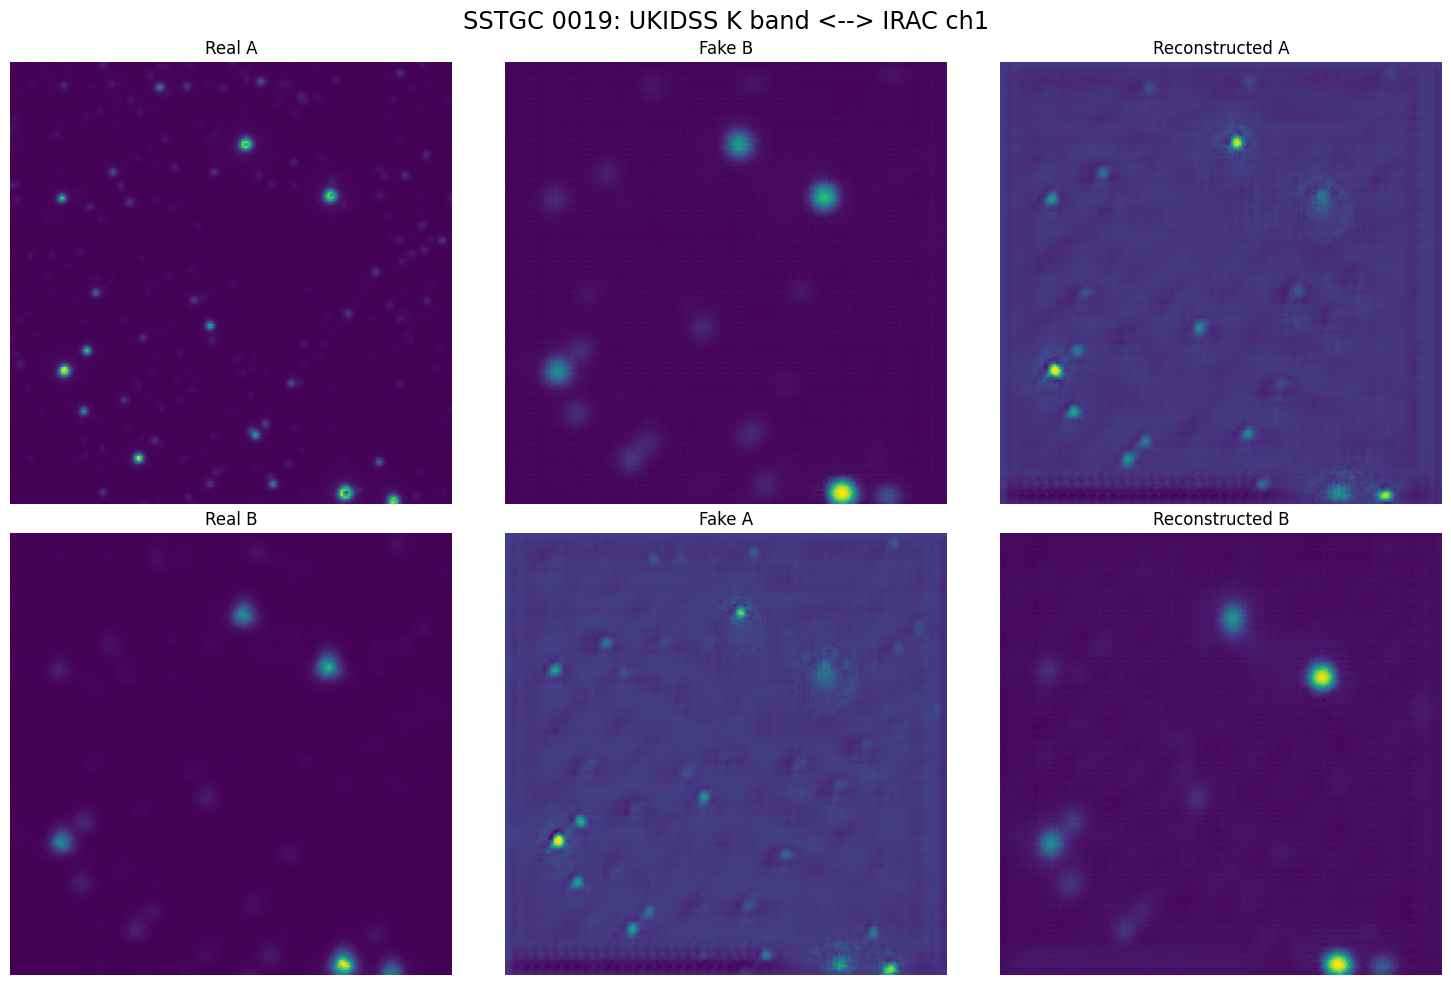

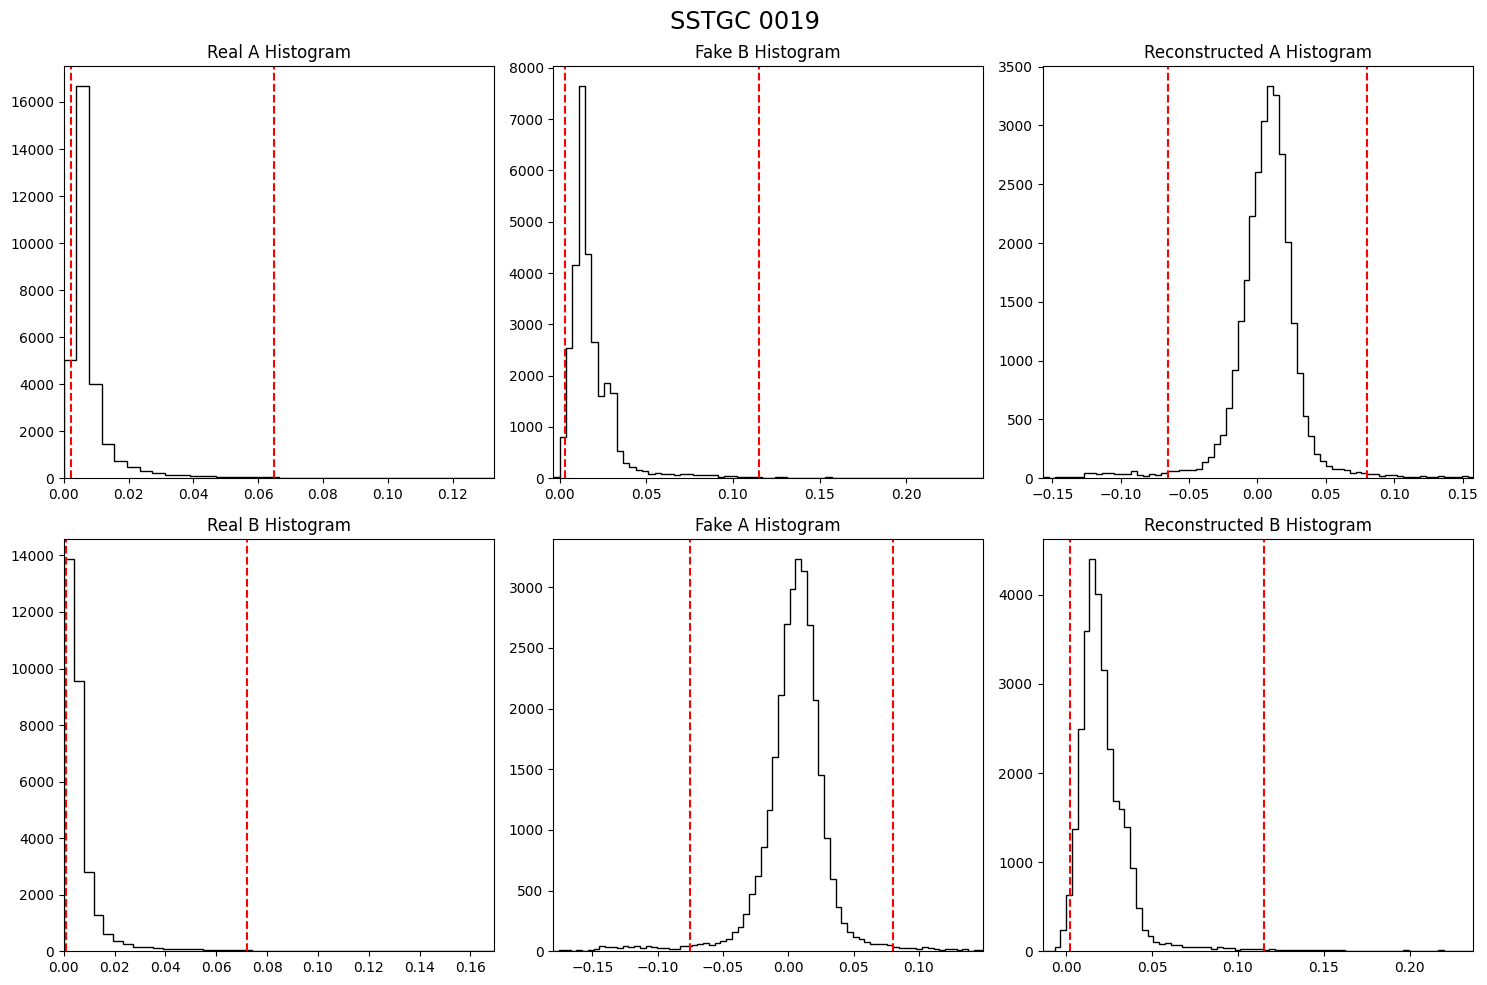

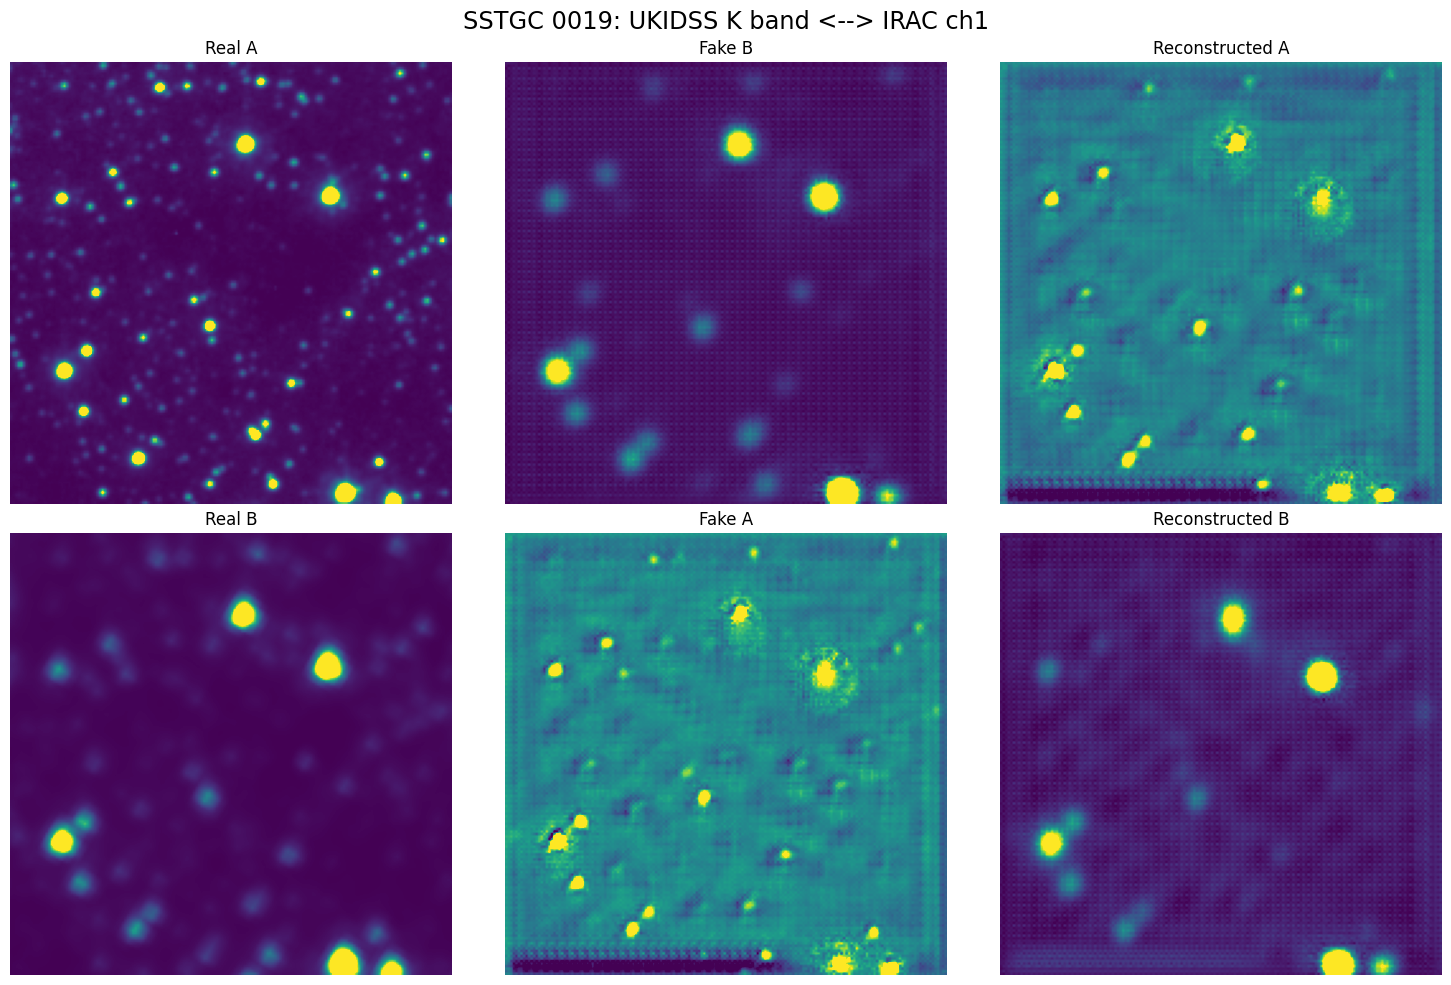

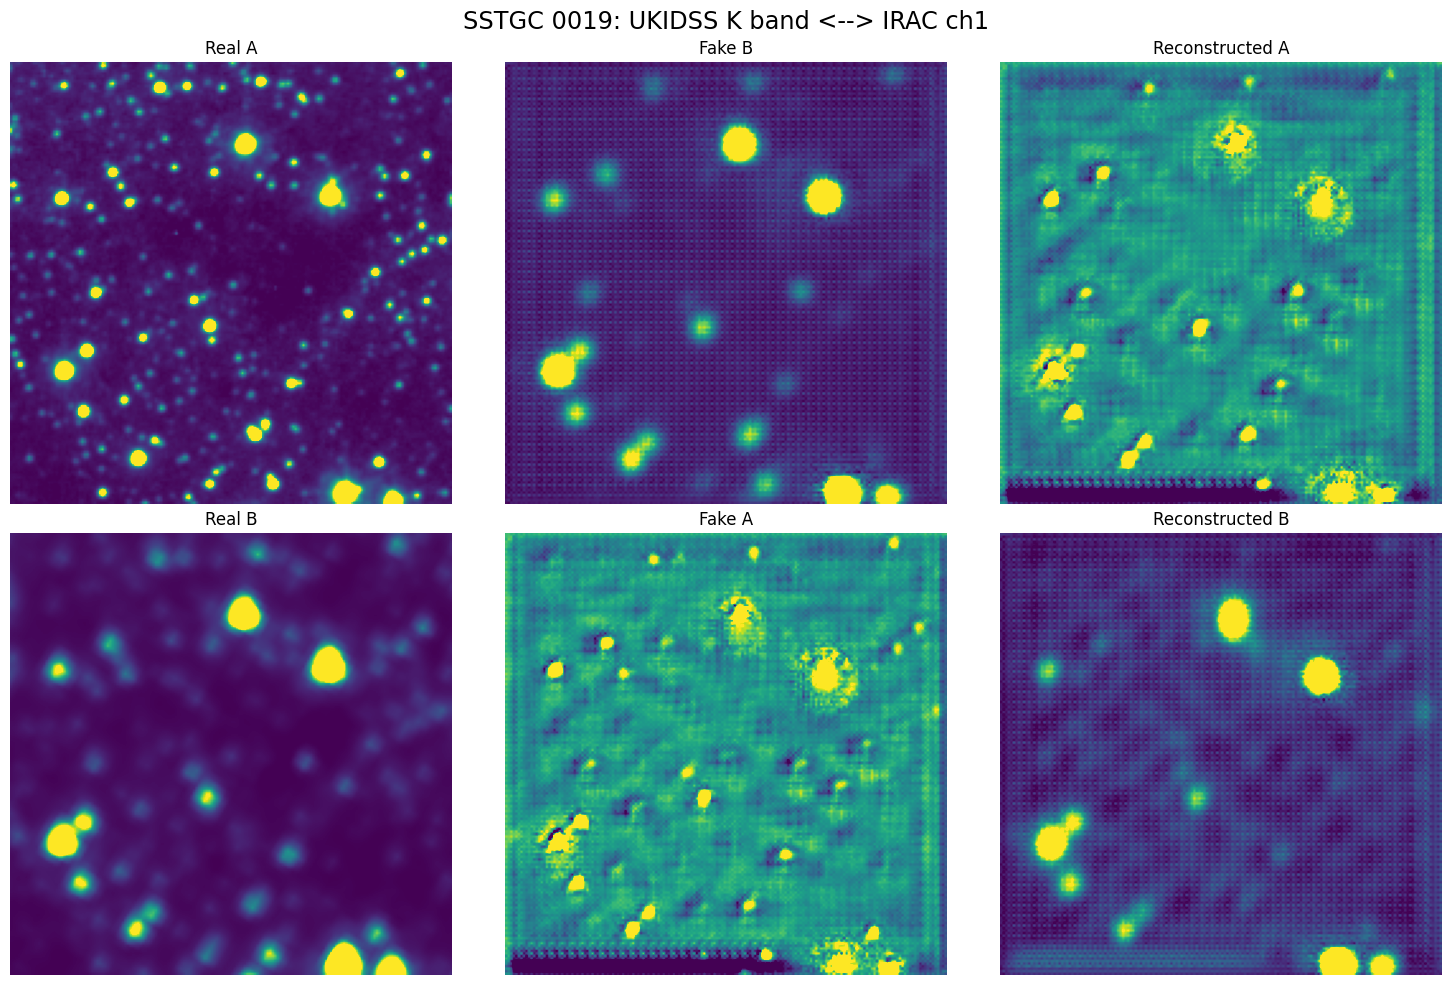

Inference completed and images are saved.


In [41]:
with torch.no_grad():
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # 시각화
        if i == 7:
            result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
                                                 recovered_A, test_real_B, fake_A, recovered_B,
                                                 channels_order=None, channel='K')
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
            result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
            break
        
        # # 결과를 저장
        # save_image(fake_B, f'{result_dir}/fake_B_{test_target_name[0]}.npy')
        # save_image(recovered_A, f'{result_dir}/recovered_A_{test_target_name[0]}.npy')

print('Inference completed and images are saved.')

### Epoch = 20

In [ ]:
with torch.no_grad(): #epoch_20
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # 시각화
        if i == 7:
            result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
                                                 recovered_A, test_real_B, fake_A, recovered_B,
                                                 channels_order=None, channel='K')
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
            result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
            break
        
        # # 결과를 저장
        # save_image(fake_B, f'{result_dir}/fake_B_{test_target_name[0]}.npy')
        # save_image(recovered_A, f'{result_dir}/recovered_A_{test_target_name[0]}.npy')

print('Inference completed and images are saved.')

In [ ]:
# Define Generator
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

# Apply Weight Initialize
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)

param_filename = load_checkpoint_for_test(netG_A2B, netG_B2A,
                                          param_dir=param_dir, stacking_size=stacking_size,
                                          status='epoch_60', pre_processed=f'{img_stacker.mark_on_name()}', 
                                          aug=None, add_suffix=add_suffix)

netG_A2B.eval()
netG_B2A.eval()
print()

### Epoch = 60

In [ ]:
with torch.no_grad(): #epoch_60
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # 시각화
        if i == 7:
            result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
                                                 recovered_A, test_real_B, fake_A, recovered_B,
                                                 channels_order=None, channel='K')
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
            result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
            break
        
        # # 결과를 저장
        # save_image(fake_B, f'{result_dir}/fake_B_{test_target_name[0]}.npy')
        # save_image(recovered_A, f'{result_dir}/recovered_A_{test_target_name[0]}.npy')

print('Inference completed and images are saved.')

### Epoch = 100

In [46]:
# Define Generator
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

# Apply Weight Initialize
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)

param_filename = load_checkpoint_for_test(netG_A2B, netG_B2A,
                                          param_dir=param_dir, stacking_size=stacking_size,
                                          status='epoch_100', pre_processed=f'{img_stacker.mark_on_name()}', 
                                          aug=None, add_suffix=add_suffix)

netG_A2B.eval()
netG_B2A.eval()
print()

Loaded checkpoint from: 
/home/jiwon/UKIDSSxIRAC/result/model_params/CycleGAN_checkpoint_epoch_100_174x174_6_channels_to_6_channels_registration_sparse_cropped_VVV_norm.pth



In [ ]:
with torch.no_grad(): #epoch_40
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # 시각화
        if i == 7:
            result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
                                                 recovered_A, test_real_B, fake_A, recovered_B,
                                                 channels_order=None, channel='K')
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
            result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
            break
        
        # # 결과를 저장
        # save_image(fake_B, f'{result_dir}/fake_B_{test_target_name[0]}.npy')
        # save_image(recovered_A, f'{result_dir}/recovered_A_{test_target_name[0]}.npy')

print('Inference completed and images are saved.')

### Epoch = 140

In [ ]:
# Define Generator
netG_A2B = Generator(input_nc, output_nc).to(device)
netG_B2A = Generator(output_nc, input_nc).to(device)

# Apply Weight Initialize
netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)

param_filename = load_checkpoint_for_test(netG_A2B, netG_B2A,
                                          param_dir=param_dir, stacking_size=stacking_size,
                                          status='epoch_140', pre_processed=f'{img_stacker.mark_on_name()}', 
                                          aug=None, add_suffix=add_suffix)

netG_A2B.eval()
netG_B2A.eval()
print()

In [ ]:
with torch.no_grad(): #epoch_60
    for i, (test_real_A, test_real_B, test_target_name) in enumerate(test_loader):
        test_real_A = test_real_A.to(device)
        test_real_B = test_real_B.to(device)
        
        fake_B = netG_A2B(test_real_A)
        recovered_A = netG_B2A(fake_B)

        fake_A = netG_B2A(test_real_B)
        recovered_B = netG_A2B(fake_A)

        # 시각화
        if i == 7:
            result_visualizer = ResultVisualizer(test_target_name, test_real_A, fake_B,
                                                 recovered_A, test_real_B, fake_A, recovered_B,
                                                 channels_order=None, channel='K')
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=False)
            result_visualizer.result_histogram(set_color_scale=True, percentile_range=(2,98))
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True)
            result_visualizer.result_plot(show_colorbar=False, set_color_scale=True, percentile_range=(2,98))
            break
        
        # # 결과를 저장
        # save_image(fake_B, f'{result_dir}/fake_B_{test_target_name[0]}.npy')
        # save_image(recovered_A, f'{result_dir}/recovered_A_{test_target_name[0]}.npy')

print('Inference completed and images are saved.')